# Analysis tutorial.

This notebook goes through the (relevant) commands from the Starlink Analysis tutorial worked examples. It skips those that are entirely GUI based. This assumes that you have downloaded the Starlink Analysis tutorial and have unpacked the data. 

You can see the non-python version of this tutorial at:
http://www.eaobservatory.org/jcmt/science/reductionanalysis-tutorials/starlink-analysis/

You can download the provided data from:
http://ftp.eao.hawaii.edu/pub/jcmt/usersmeetings/JCMT_tutorial_2018_Starlink_Analysis.tar.gz


## Getting Help 
Remeber that you can get help on a command with
`help(module.commandname)` or `module.commandname?` in jupyter.

You may also need to look at the Starlink on-line documentation. The KAPPA manual is at http://www.starlink.ac.uk/docs/sun95.htx/sun95.html

The documentation on the Starlink-pywrapper module is available at http://starlink-pywrapper.readthedocs.io/en/latest/

Shell commands are shown using the magic `%` (for a single magic command) or to have an entire cell that is running shell commands you can use `%%script bash`; these work in jupyter notebooks but will not work in a normal Python script.


## Starting the module
First of all we start up the package and import what we need, and set the location of the Starlink Software installation to use. We'll also set up a logging handler (this may sometimes already exist, depending on how your jupyter notebook is configured).

In [1]:
from starlink import wrapper, kappa, convert, cupid
import logging
logging.basicConfig(level=logging.INFO)
logging.root.setLevel(logging.INFO)

import numpy as np

Could not find Starlink: please run change_starpath("/path/to/star")


In [2]:
wrapper.change_starpath('/Users/sarah/star-2017A')

The next thing we need to is make sure we are in the directory where we unpacked the data.

In [3]:
import os
os.chdir('/Users/sarah/SeoulUsersMeeting/Starlink_Analysis') # replace with the path to where the data is for you.

# Getting started with your data. 


## Task: Convert a Frequency based FITS cube a to Radio Velocity NDF file

**Take an archival FITS HARP cube (one is provided in this tutorial: jcmth20061220_00044_01_reduced001_nit_000.fits), convert it to NDF and change the 3rd axis from Frequency to radio velocity. Also change the standard of rest from barycentric to LSRK.**

First of all, we will convert the FITS file (downloaded from the JCMT Science Archive) to NDF format, using the convert package's [`fits2ndf`](http://www.starlink.ac.uk/cgi-bin/htxserver/sun55.htx/sun55.html?xref_FITS2NDF) command:

In [4]:
# Set up the names
fitscube = 'jcmth20061220_00044_01_reduced001_nit_000.fits'
cube = 'co32_cube.sdf'

# Create the SDF file.
convert.fits2ndf(fitscube, cube)

   fmtcnv    TRUE
  profits    True
container    False
      in_    jcmth20061220_00044_01_reduced001_nit_000.fits
  proexts    True
  wcscomp    WCS
      out    co32_cube.sdf

We can use [`ndftrace`](http://www.starlink.ac.uk/cgi-bin/htxserver/sun95.htx/sun95.html?xref_NDFTRACE) to examine the cube. If you want to see the string output normally displayed to screen, turn the logging level to DEBUG.

In [5]:
ndftrace = kappa.ndftrace(cube)
print(ndftrace)

 variance    True
    fubnd    [1.7236123539655122, 0.07521704716547964, 346.2169257726615]
  exttype    ['_CHAR*80', 'SMURF_EXT', 'PROVENANCE']
  current    5
  quality    False
fpixscale    ['5.99999', '5.99999', '0.0004882367']
   flabel    ['Right ascension', 'Declination', 'Frequency (USB)']
     zero    0.0
 fullaxis    False
     ndim    3
    funit    ['hh:mm:ss.s', 'ddd:mm:ss', 'GHz']
     dims    [119, 118, 1880]
     fdim    [3, 3, 3, 3, 3]
fullframe    False
  fullwcs    False
  fdomain    ['GRID', 'PIXEL', 'AXIS', 'FRACTION', 'SKY-DSBSPECTRUM']
   ubound    [61, 59, 939]
   nframe    5
     form    SIMPLE
    label    TA*   corrected antenna temperature
   ftitle    [ Data grid indices; first pixel at (1,1,1)
               Pixel coordinates; first pixel at (-57.5,-58.5,-940.5)
               Axis coordinates; first pixel at (-57.5,-58.5,-940.5)
               Normalised pixel coordinates; first pixel at (0.004201681,0.004237288,0.00026595
               3-d compound coord

If you've not used the `starlink-pywrapper` module before, the return value from Starlink commands is a `namedtuple` object, where every value normally written into the ADAM directory's parameter file for that command. This lets you programatically access the return values without having to grep string output. (For advanced Starlink users, this is the equivalent of using `parget` to get the value).

As an example, the units of the frequency system are shown in `flabel`, in the 3rd item. You can view this as:

In [6]:
ndftrace.flabel[2]

'Frequency (USB)'

We can see the coordinate system by using [`wcsattrib`](http://www.starlink.ac.uk/cgi-bin/htxserver/sun95.htx/sun95.html?xref_WCSATTRIB) to get the values of the coordinate `System` on the 3rd axis, and the current standard of rest using the `StdofRest` values.

In [7]:
print(kappa.wcsattrib(cube, mode='get', name='System(3)').value)
print(kappa.wcsattrib(cube, mode='get', name='StdofRest').value)

FREQ
Barycentric


We can now set these values, also using `wcsattrib` but now using `mode='set'`. We don't have to specify which axes' `System` we are updating, as AST is intelligent enough to know that only a spectral system can be set to radio velocity.

In [8]:
kappa.wcsattrib(cube, mode='set',
                name='System', newval='vrad')
kappa.wcsattrib(cube, mode='set',
                name='StdofRest', newval='LSRK')

   ndf    co32_cube.sdf
 value    Barycentric
 state    True
newval    LSRK
  name    StdofRest
  mode    set
 remap    True

We can see this command has worked by seeing what `ndftrace` produces:

In [9]:
ndftrace = kappa.ndftrace(cube)
print(ndftrace.flabel[2])
print(ndftrace.fpixscale[2], ndftrace.funit[2])


Radio velocity (USB)
0.4233065 km/s


## 2. See what is in your file

**Can you programatically identify the molecule and transition, original observation date, find out if the autogrid option was used in the original makecube command, and when that command was run? Identify the original observations and see what extensions are present.**

### Getting information from the FITS headers.
JCMT SDF files have a FITS extension which holds FITS-style header values holding metadata about the original observation and telescope data.  One way to read out a single FITS header value from an NDF is to use [`kappa.fitsval`](http://www.starlink.ac.uk/cgi-bin/htxserver/sun95.htx/sun95.html?xref_FITSVAL), as:


In [10]:
molecule = kappa.fitsval(cube, 'MOLECULE').value
transition = kappa.fitsval(cube, 'TRANSITI').value
print(molecule, transition)

CO 3  - 2


However, if you need a lot of things from the FITS header `fitsval` can be slow; it reads the file for each call you make.

You can't easily use KAPPA's FITSLIST as that command only prints to screen, so it does not return useful information. However, if you have `astropy` installed there is a convenience method in the utilities module that will read in the FITS extension of an NDF file and return it as an Astropy Header object. You can run this as:

In [11]:
from starlink import utilities
fitsheader = utilities.get_ndf_fitshdr(cube)
print(type(fitsheader))
fitsheader


<class 'astropy.io.fits.header.Header'>


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  119 / length of data axis 1                          
NAXIS2  =                  118 / length of data axis 2                          
NAXIS3  =                 1880 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
LBOUND1 =                  -57 / Pixel origin along axis 1                      
LBOUND2 =                  -58 / Pixel origin along axis 2                      
LBOUND3 =                 -940 / Pixel origin along axis 3                      
LABEL   = 'T%s60+%v30+A%^50+

You can then access individual FITS headers just as you do with `pyfits` or `astropy.io.fits` header objects:

In [12]:
molecule = fitsheader['MOLECULE']
transition = fitsheader['TRANSITI']
date_obs = fitsheader['DATE-OBS']
print(molecule, transition, '\n', date_obs)

CO 3  - 2 
 2006-12-20T09:55:34.018


### Getting provenance and history information.

Unfortunately, the `hislist` and `provshow` commands also write values only to the screen, and we have not yet implemented a utility function to get the values for you. Normally it isn't necessary to read these components in your scripts. You can get the normal output as a string if it is needed in your programby using the `returnstdout=True` keyword argument:

In [13]:
kappa.hislist(cube)

brief    False
  ndf    co32_cube.sdf

In [14]:
hislist, histstring = kappa.hislist(cube, returnstdout=True)
print(hislist)
print(histstring)

brief    False
  ndf    co32_cube.sdf

   History listing for NDF structure /Users/sarah/SeoulUsersMeeting/Starlink_Analysis/co32_cube:

   History structure created 2014 Nov 20 09:22:05.443

1: 2014 Nov 20 09:22:05.538 - MAKECUBE        (SMURF V1.6.0)

   Parameters: ALIGNSYS=FALSE AUTOGRID=TRUE BADMASK='and' CROTA=0
      DETECTORS=! FBL=[1.7235973391403,0.071799010054101]
      FBR=[1.7201560002942,0.071799006183432]
      FLBND=[1.7201409775556,0.07178446001926,-381.34682629178]
      FUBND=[1.7236123539655,0.07521704716548,414.46932659916]
      FTL=[1.7235977665515,0.075202393861675]
      FTR=[1.7201555650017,0.075202389806852] GENVAR='tsys'
      IN=@^oractempXdGhiP INWEIGHT=TRUE JSATILES=FALSE LBND=[-57,-58]
      LBOUND=[-57,-58,-940] NPOLBIN=1 NTILE=1 OUT=@ga20061220_44_1_cube
      OUTCAT=! PIXREF=[60.461,60.045] PIXSIZE=6 POSERRFATAL=FALSE REF=!
      REFLAT='4:12:43.9' REFLON='6:34:37.72' REFPIX1=60.461 REFPIX2=60.045
      SPARSE=FALSE SPECBOUNDS='-381.347,414.469' SPECU

You would then have to grep this result yourself -- very inconvenient.


Technically, you can use the `starlink.hds` package to look at this more programmatically, but it doesn't have any helpful convenience methods. Its very unlikely this is ever worth doing this way, but you could theoretically find out what the `autogrid` value was set to in the original `makecube` gridding command applied to the data by running:

In [15]:
from starlink import hds
hdsloc = hds.open(cube, 'READ')
histstruc = hdsloc.find('HISTORY').find('RECORDS')
entries = histstruc.shape[0]
for i in range(entries):
    entry = histstruc.cell([i])
    try:
        comname  = entry.find('COMMAND').get().decode()
        if comname.startswith('MAKECUBE'):
            options = entry.find('TEXT').get()
            options = '\n'.join([i.decode() for i in options])
            print(options)
            if 'AUTOGRID=TRUE' in options:
                autogrid = True
            else:
                autogrid = False
    except:
        pass
print(' Autogrid was set to {}'.format(autogrid))

Parameters: ALIGNSYS=FALSE AUTOGRID=TRUE BADMASK='and' CROTA=0          
   DETECTORS=! FBL=[1.7235973391403,0.071799010054101]                  
   FBR=[1.7201560002942,0.071799006183432]                              
   FLBND=[1.7201409775556,0.07178446001926,-381.34682629178]            
   FUBND=[1.7236123539655,0.07521704716548,414.46932659916]             
   FTL=[1.7235977665515,0.075202393861675]                              
   FTR=[1.7201555650017,0.075202389806852] GENVAR='tsys'                
   IN=@^oractempXdGhiP INWEIGHT=TRUE JSATILES=FALSE LBND=[-57,-58]      
   LBOUND=[-57,-58,-940] NPOLBIN=1 NTILE=1 OUT=@ga20061220_44_1_cube    
   OUTCAT=! PIXREF=[60.461,60.045] PIXSIZE=6 POSERRFATAL=FALSE REF=!    
   REFLAT='4:12:43.9' REFLON='6:34:37.72' REFPIX1=60.461 REFPIX2=60.045 
   SPARSE=FALSE SPECBOUNDS='-381.347,414.469' SPECUNION=TRUE            
   SPREAD='NEAREST' SYSTEM='tracking' TILEBORDER=0 TILEDIMS=-256        
   TRIM=FALSE TRIMTILES=TRUE UBND=[61,59] UBOUND=[6

It is not common to need to do this however -- normally examining the history structure isn't required in scripts. Please contact the observatory if you have a usecase where you need to get to this.

## Plotting the scan pattern of an SCUBA-2 map.

This is another hard one. The telescope information is kept in RAW files in the `jcmtstate` extension. Starlink provides a convenience function to write out this data to a catalogue -- the `jsastate2cat` command in SMURF -- but this is not currently available in this wrapper. (The command actually runs a perl script unlike most Starlink commands). 


However, you can plot a file made with this command easily in Python. An example `jcmtstate2cat` file is included in the Starlink_Analysis tutorial tar ball, as the file `jcmtstate_s20120501_00068.TST`.

I recommend using the Astropy table module to read in the table -- if you've never used this it handles most Astronomical table formats (and usefully can also write out your output in Latex, for easy incorporation into papers), and is very powerful. You would use it as:





In [16]:
from astropy.table import Table
cat = 'jcmtstate_s20120501_00068.TST'
table = Table.read('jcmtstate_s20120501_00068.TST', format='ascii.tab', guess=False, data_start=2)
print(table)

  Id    RA DEC DRA ...     WVM_T42          WVM_T78          WVM_TIME    
------ --- --- --- ... ---------------- ---------------- ----------------
135917 nan nan nan ... 87.6182861328125 64.7868728637695 56048.6981869227
135918 nan nan nan ... 87.6182861328125 64.7868728637695 56048.6981869227
135919 nan nan nan ... 87.6182861328125 64.7868728637695 56048.6981869227
135920 nan nan nan ... 87.6182861328125 64.7868728637695 56048.6981869227
135921 nan nan nan ... 87.6182861328125 64.7868728637695 56048.6981869227
135922 nan nan nan ... 87.6182861328125 64.7868728637695 56048.6981869227
135923 nan nan nan ... 87.6182861328125 64.7868728637695 56048.6981869227
135924 nan nan nan ... 87.6182861328125 64.7868728637695 56048.6981869227
135925 nan nan nan ... 87.6182861328125 64.7868728637695 56048.6981869227
135926 nan nan nan ... 87.6182861328125 64.7868728637695 56048.6981869227
   ... ... ... ... ...              ...              ...              ...
193206 nan nan nan ... 89.324249267578

Please note that you have to tell `Table.read` to start on line 2, to avoid an issue with a comment line that causes the reader problems.

You can then use `matplotlib` to plot the DDRA vs DDDec. Matplotlib is the standard Python plotting library, and there are many tutorials available online if you haven't used it:

Text(0,0.5,'DDEC')

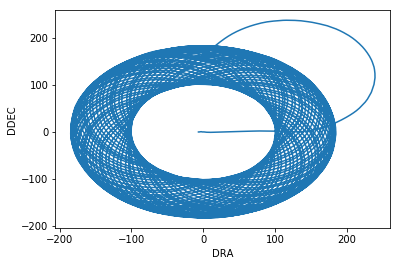

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(table['DRA'], table['DDEC'])
plt.xlabel('DRA')
plt.ylabel('DDEC')

## Measuring Noise in the Map

### 1. Comparing noise estimates:
**Compare the noise estimated across a blank region of the spectral window with the noise found in the Variance array**

In the stand alone Starlink tutorial we identify the blank region of the spectra with Gaia -- we will assume you have already done this. 


### Aside on Plotting with Starlink within Python

Although not everyone wishes to use Starlink generated plots in their papers, it is often helpful to quickly generate images from cubes and maps without converting a file or opening up a new image program. This section shows you how to make a few plots using KAPPA, as either an XWindow which will pop up on your computer, as a PNG or as an EPS appropriate for conversion to PDF. These are then embedded in this jupyter notebook using the jupyter/ipython specific display commands.

#### Plotting a spectra:

If you wanted to plot a central spectra you could do this by producing a linplot plot on a pop-up Xwindows device: (NYou have to specify the device every time; this interface may behave strangely if you try and use KAPPA's `gdset` options with XWindows plots.)

First of all we will set up a different KAPPA style file, so we don't get multicoloured lines on a black background. To set up sensible plotting defaults, we will create a  'kappa_style.def' file, following the instructions at http://www.starlink.ac.uk/docs/sun95.htx/sun95se7.html#x8-620003   We're going to use the shell command `echo` via the magic jupyter notebook commands accessed with `%`

In [18]:
%%script bash
echo "colour(border)=1" > kappa_style.def
echo "colour(grid)=1">> kappa_style.def
echo "colour(ticks)=1">> kappa_style.def
echo "colour(numlab)=1" >> kappa_style.def
echo "colour(axes)=1" >> kappa_style.def
echo "colour(keyborder)=1" >> kappa_style.def

We will now set the palette for the XW device to use WHITE for the background and BLACK for the foreground.

In [19]:
kappa.palentry(device='xw',palnum=0, colour="White")
kappa.palentry(device='xw',palnum=1, colour="Black")

INFO:starlink.wrapper:Creating xwindow named xwindows
INFO:starlink.wrapper:Creating xwindow named xwindows


device    xw
palnum    1
colour    Black

This popped up an Xwindows device -- you can safely close this.

We could specify our style options by always passing `style='^kappa_style.def`, but we can also set this as a default by saving the name of the style file in the environmental variables `KAPPA_LINPLOT_STYLE` and `KAPPA_DISPLAY_STYLE`. If you wish to use other plotting commands you could also create default plotting options for those commands in this way. We save these in the `wrapper.env` dictionary, which defines the environmental variables which are used when running Starlink commands in this module.

In [21]:
wrapper.env['KAPPA_LINPLOT_STYLE'] = 'kappa_style.def'
wrapper.env['KAPPA_DISPLAY_STYLE'] = 'kappa_style.def'

You can now plot the spectrum at PIXEL position (0,0,) (normally near the center of the map) into a pop-up Xwindow with:

In [22]:
kappa.linplot(ndf=cube + '(0,0,)', device='xw')#Alternatively, add style='^kappa_style.def' to use a style file.

INFO:starlink.wrapper:Creating xwindow named xwindows


device    xw
  comp    Data
 clear    True
 lmode    Extended
  xmap    Default
   ndf    co32_cube.sdf(0,0,)
errbar    False
  mode    Line
  ymap    Linear

You will have to specify `device=` everytime you use plotting commands; the gdset command will not work for XWindows through this Python wrapper. You also can't abbreviate `device=` to `dev=` as you can on the command line.

You could also write your images to a PNG file with a white background. The default for the PNG device is White on Black, so we will again need to change the `palentry` options for this device.  Here we're going to try and plot two spectra, one from (0,0) and one from (5,5) on top of each other. The commands to create two PNG files suitable for merging is:

In [23]:
kappa.palentry(device='/PNG',palnum=0,colour="White")
kappa.palentry(device='/PNG',palnum=1, colour="Black")
kappa.linplot(cube + '(0,0,)', device='myfile.png/PNG')
kappa.linplot(cube + '(5,5,)', device='myfile2.png/TPNG', style='+colour(line)=red', clear=False)

device    myfile2.png/TPNG
  comp    Data
 style    !
 lmode    Extended
  xmap    Default
   ndf    co32_cube.sdf(5,5,)
errbar    False
  mode    Line
 clear    False
  ymap    Linear

You can show these PNG files in the jupyter notebook like so:

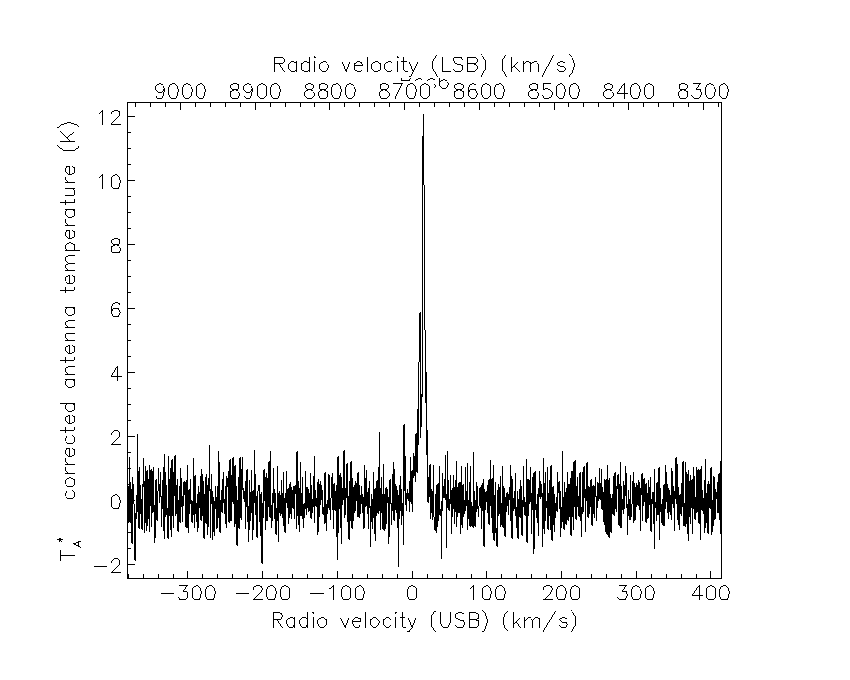

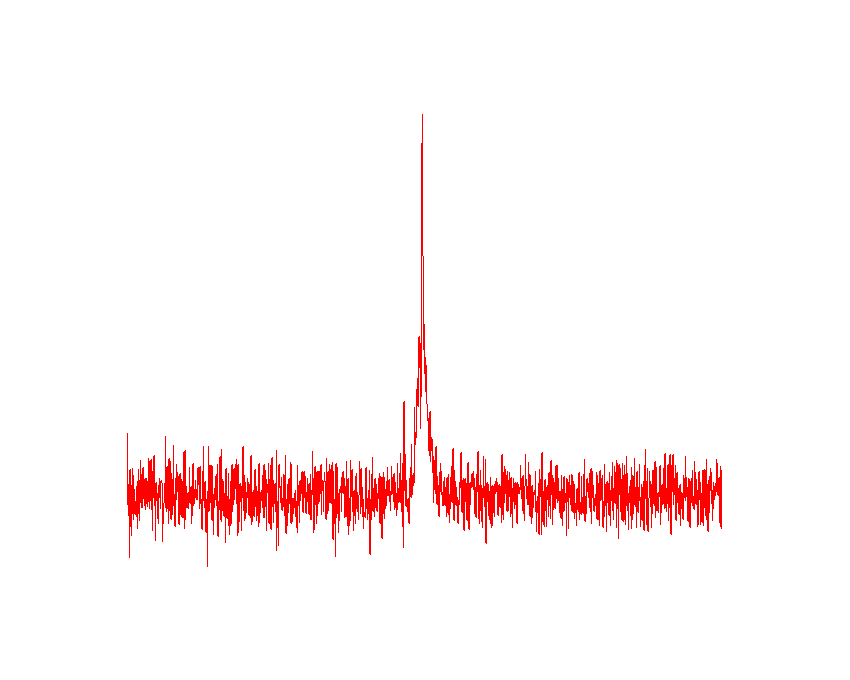

In [24]:
from IPython.display import Image, display
display(Image('myfile.png', width=500))
display(Image('myfile2.png', width=500))

You can merge these using the ImageMagick convert command, if you have it installed on your computer, and then display the resulting PNG file in the notebook:

In [25]:
%%script bash
"convert" myfile2.png -transparent gray90 myfile2.png
"convert" myfile.png myfile2.png -composite myfile.png

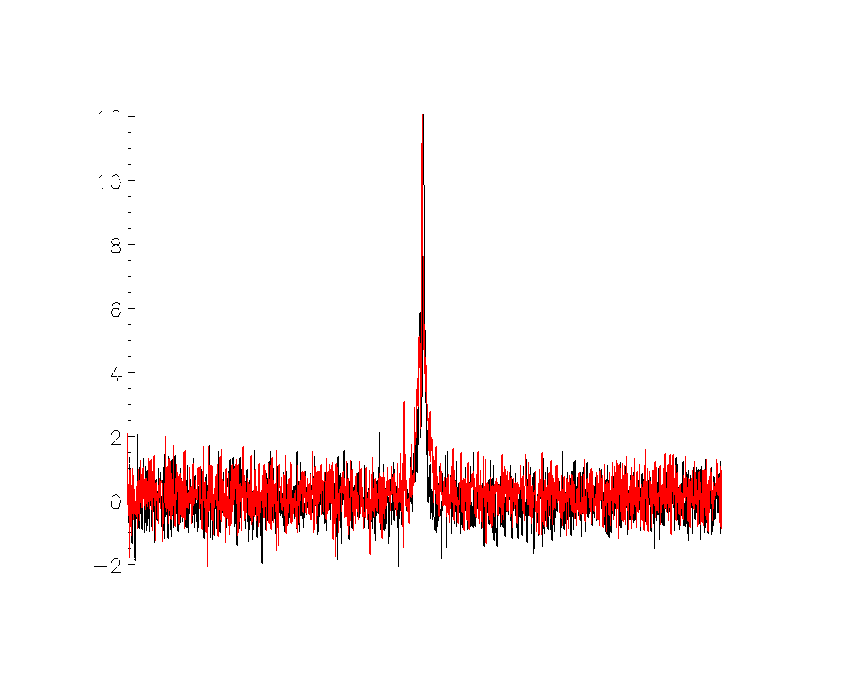

In [26]:
display(Image('myfile.png', width=500))

You can also write to Enscapsulated PostScript files, and then convert to pdf. You should use the 'accumulating' post script device, otherwise you will have to manually merge the files with psmerge. These are:

`apscol_p  (/AVCPS)         Accumulating EPS, color, portrait`

`apscol_l  (/ACPS)          Accumulating EPS, color, landscape`

You should also put sensible Postscript fonts in. You can select any of the standard PGPLOT PostScript fonts: "Times", "Helvetica", "Courier", "NewCentury" or  "Zapf" by running:

In [27]:
kappa.wrapper.env['PGPLOT_PS_FONT'] =  'Helvetica'

You can then produce the postscript plots with:

In [28]:
# These few lines aren't normally necessary, they are just to clear the output
# from the accumulating graphics device if you are repeatedly running this in the jupyter notebook .
if os.path.isfile('myfile.eps'):
    os.remove('myfile.eps')
kappa.gdclear(device='/AVCPS')

# Here are the commands to run this.
kappa.linplot(cube + '(0,0,)', device='myfile.eps/AVCPS', style='^kappa_style.def', clear=True)
kappa.linplot(cube + '(50,50,)', device='myfile.eps/AVCPS', style='+colour(line)=red', clear=False)

  device    myfile.eps/AVCPS
    comp    Data
   style    !
alignsys    Data
    xmap    Default
     ndf    co32_cube.sdf(50,50,)
  errbar    False
    mode    Line
   clear    False
    ymap    Linear

We can convert these EPS files into a PDF file so we can easily use it with the ps2pdf ocmmand (this will only work if that command is installed on your computer).

In [29]:
%%script bash
# Convert to PDF (assumes you have ps2pdf on your computer)
ps2pdf -dEPSCrop myfile.eps
ls *.pdf

myfile.pdf


We can then display this PDF inside our notebook with:

In [30]:
from IPython.display import IFrame
IFrame("Starlink_Analysis/myfile.pdf", width=500, height=400)

#### Returning to our original task:

We have identified the line free region of the map as -265.0 to -78 km/s. We now want to [`collapse`](http://www.starlink.ac.uk/cgi-bin/htxserver/sun95.htx/sun95.html?xref_COLLAPSE) our cube over that range on the third axis, and use either the `estimator='rms'` or `estimator='sigma'` so that we have a measurement of the nosie.

(The collapse command is extremely useful, and I recommend exploring the different estimator options in the documentation: http://www.starlink.ac.uk/cgi-bin/htxserver/sun95.htx/sun95.html?xref_COLLAPSE).

In [31]:
noisemap ='co32_noise.sdf'
kappa.collapse(in_=cube, out=noisemap, estimator='rms', low=-265.0, high=-78.0, axis='vrad')

      low    -265.0
     axis    vrad
     wlim    0.3
estimator    rms
      in_    co32_cube.sdf
     high    -78.0
 variance    True
     trim    True
     comp    Data
      out    co32_noise.sdf

We will now use the [`stats`](http://www.starlink.ac.uk/cgi-bin/htxserver/sun95.htx/sun95.html?xref_STATS) command to get the mean and width of the noise distribution across the map.

In [33]:
stats = kappa.stats(noisemap)
print(u'Noise on map is: {:.2F}±{:.2F}'.format(stats.mean, stats.sigma))

Noise on map is: 0.83±0.39


For interest, you can plot this noise map as:

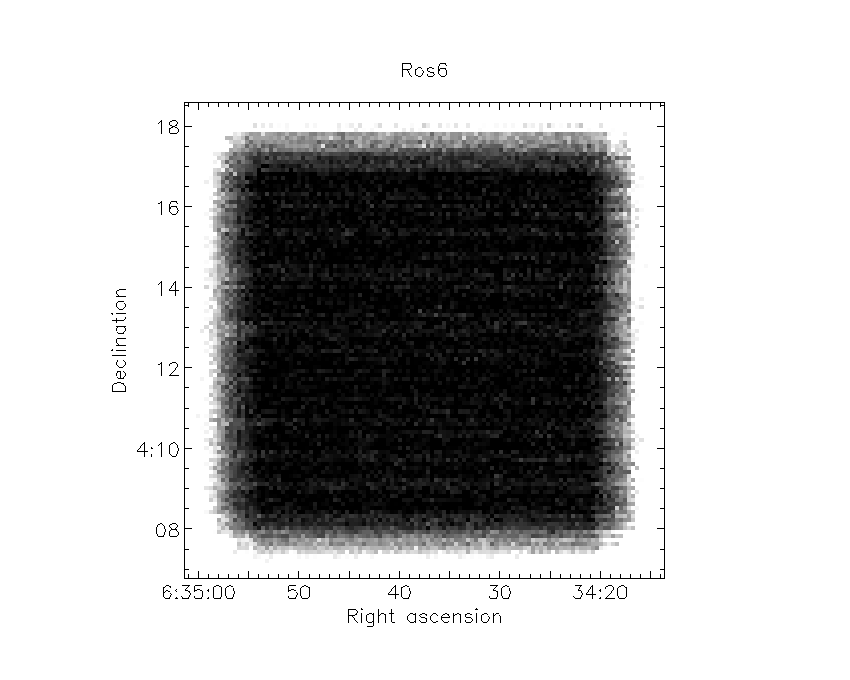

In [34]:
kappa.display(noisemap, mode='percent', percentiles=[20,80],device='noise.png/PNG')
display(Image('noise.png'))

## Regrid map to 1km/s and check the new noise

We can regrid with the [`kappa.sqorst`](http://www.starlink.ac.uk/cgi-bin/htxserver/sun95.htx/sun95.html?xref_SQORST) command. If you look at the Starlink-pywrapper documentation, you'll see that the Python wrapper thinks that the 'factors' argument is a required keyword -- in fact, we are going to use the pixelscale mode, so it won't matter what value we set the factors to be. You can use the '!' character to tell Starlink to accept the default.

In [35]:
squashedmap = 'co32_1kms_cube.sdf'
kappa.sqorst(in_=cube, out=squashedmap, factors='!', axis=3, mode='pixelscale', pixscale=1.0)
ndftrace = kappa.ndftrace(squashedmap)
print('3rd axis pixel scale is now {} {}'.format(ndftrace.fpixscale[2], ndftrace.funit[2]))

3rd axis pixel scale is now 1 km/s


As we did before, we will now `collapse` the cube using the `rms` estimator over our line free region, and calculate the mean of the RMS noise and the width of the noise distribution from `stats`:

In [36]:
noise1kms = 'co32_1kms_noise.sdf'
kappa.collapse(squashedmap, out=noise1kms, estimator='rms', low=-265.0, high=-78.0, axis='vrad')
stats1kms = kappa.stats(noise1kms)
print(u'Noise on rebinned map is: {:.2F}±{:.2F}'.format(stats1kms.mean, stats1kms.sigma))

Noise on rebinned map is: 0.59±0.28


If you want, you can also checks that this is close to the expected value predicted by the radiometer equation. The radiometer equation says that:

$$\frac{RMS_{old}}{RMS_{new}} = \sqrt{\frac{ChanWidth_{old}}{ChanWidth_{new}}}$$

In [37]:
# check this follows the radiometer equation: RMS_old/RMS_new = sqrt(channel_old (ghz)/channel_new (ghz))

newchannel_width = float(kappa.ndftrace(cube).fpixscale[2])
oldchannel_width = float(kappa.ndftrace(squashedmap).fpixscale[2])

import numpy as np
print(stats.mean/stats1kms.mean)
print(np.sqrt(oldchannel_width/newchannel_width))


1.416283867357542
1.5369952713656245


#### We can also compare with the noise in the square root of the Variance array
Starlink reduced cubes and maps have a VARIANCE array, and commands like `stats` can access the square root of this array directly by passing the `comp='error'` on the command line.

In [38]:
stats_var = kappa.stats(cube, comp='error')
stats_var_1kms = kappa.stats(squashedmap, comp='error')
print('Noise from VARIANCE component before regridding is {:.2F}±{:.2F}'.format(stats_var.mean, stats_var.sigma))
print('Noise from VARIANCE component after regridding is {:.2F}±{:.2F}'.format(stats_var_1kms.mean, stats_var_1kms.sigma))

Noise from VARIANCE component before regridding is 0.78±0.38
Noise from VARIANCE component after regridding is 0.55±0.27


## Masking, Extracting and Trimming

### Extract a region using WCS coordinates.

Try and extract the region from RA/Dec diagonal corners:(18:53:16, 1:14:35) to (18:53:01, 1:18:27.63) from the `scuba2_map.sdf` file provided for this tutorial.

You can use NDF sections for this, along with ndfcopy (see http://www.starlink.ac.uk/cgi-bin/htxserver/sun95.htx/sun95.html?xref_se_ndfsect):

In [39]:
mapfile = 'scuba2_map.sdf'
ndfsection = '(18:53:16;18:53:01,1:14:35;1:18:27.63)' # note no spaces.

regionfile = 'subregion.sdf'
kappa.ndfcopy(mapfile+ndfsection, out=regionfile)

    out    subregion.sdf
   trim    False
   comp    DATA
    in_    scuba2_map.sdf(18:53:16;18:53:01,1:14:35;1:18:27.63)
trimbad    False
  exten    False
trimwcs    True

In [40]:
logging.root.setLevel('DEBUG')
print(kappa.ndftrace(regionfile))
logging.root.setLevel('INFO')

DEBUG:starlink.wrapper:['/Users/sarah/star-2017A/bin/kappa/ndftrace', 'subregion.sdf']
DEBUG:starlink.wrapper:
   NDF structure /Users/sarah/SeoulUsersMeeting/Starlink_Analysis/subregion:
      Title:  G34.3
      Label:  Flux Density
      Units:  mJy/beam

   Shape:
      No. of dimensions:  2
      Dimension size(s):  57 x 59
      Pixel bounds     :  11:67, -5:53
      Total pixels     :  3363

   Data Component:
      Type        :  _DOUBLE
      Storage form:  SIMPLE
      Bad pixels may be present

   Variance Component:
      Type        :  _DOUBLE
      Storage form:  SIMPLE
      Bad pixels may be present

   Quality Component:
      Type        :  _UBYTE
      Storage form:  SIMPLE
      Bad-bits mask:  0 (binary 00000000)

   World Co-ordinate Systems:
      Number of co-ordinate Frames: 6

      Current co-ordinate Frame (Frame 6):

        Frame title         : "FK5 equatorial coordinates; mean equi..."
        Domain              : SKY
        First pixel centre  : 18:53

 variance    True
    fubnd    [4.944813463935276, 0.02282648180847199]
  exttype    ['SMURF_EXT', '_CHAR*80', 'PROVENANCE']
  current    6
  quality    True
fpixscale    ['4.00000', '4.00000']
   flabel    ['Right ascension', 'Declination']
     zero    0.0
 fullaxis    False
     ndim    2
    funit    ['hh:mm:ss.sss', 'ddd:mm:ss.ss']
     dims    [57, 59]
     fdim    [2, 2, 2, 2, 3, 2]
  fullwcs    False
  fdomain    ['GRID', 'PIXEL', 'AXIS', 'FRACTION', 'SKY-SPECTRUM', 'SKY']
   ubound    [67, 53]
   nframe    6
     form    SIMPLE
    label    Flux Density
  history    True
   ftitle    [ Data grid indices; first pixel at (1,1)
               Pixel coordinates; first pixel at (10.5,-5.5)
               Axis coordinates; first pixel at (10.5,-5.5)
               Normalised pixel coordinates; first pixel at (0.00877193,0.008474576)
               3-d compound coordinate system
               FK5 equatorial coordinates; mean equinox J2000.0
             ]
      ndf    subregion.sdf


### Crop a SCUBA-2 map with PICARD

Picard is availabe as its own module:

In [41]:
from starlink import picard, utilities
utilities.starhelp(picard)

calc_scuba2_avpspec      : Run PICARD'S CALC_SCUBA2_AVPSPEC recipe.
calc_scuba2_fcf          : Run PICARD'S CALC_SCUBA2_FCF recipe.
calc_scuba2_nefd         : Run PICARD'S CALC_SCUBA2_NEFD recipe.
calibrate_scuba2_data    : Run PICARD'S CALIBRATE_SCUBA2_DATA recipe.
coadd_jsa_tiles          : Run PICARD'S COADD_JSA_TILES recipe.
create_moments_map       : Run PICARD'S CREATE_MOMENTS_MAP recipe.
create_png               : Run PICARD'S CREATE_PNG recipe.
crop_scuba2_images       : Run PICARD'S CROP_SCUBA2_IMAGES recipe.
estimate_image_alignment : Run PICARD'S ESTIMATE_IMAGE_ALIGNMENT recipe.
jsa_catalogue            : Run PICARD'S JSA_CATALOGUE recipe.
mosaic_jcmt_images       : Run PICARD'S MOSAIC_JCMT_IMAGES recipe.
picard_demonstrator      : Run PICARD'S PICARD_DEMONSTRATOR recipe.
scuba2_check_cal         : Run PICARD'S SCUBA2_CHECK_CAL recipe.
scuba2_check_rms         : Run PICARD'S SCUBA2_CHECK_RMS recipe.
scuba2_display_pca       : Run PICARD'S SCUBA2_DISPLAY_PCA recipe.
scuba2_ja

Unfortunately, the help for these recipe-specific PICARD commands has not yet been created, so `?` and `help()` don' show you the call signature. The actual command you need to use is the same as that of the `wrapper.picard` command, but without specifying the recipe. Please see the Starlink PICARD documentation (http://www.starlink.ac.uk/cgi-bin/htxserver/sun265.htx/sun265.html for full details on what the recipes actually do.

In [42]:
help(wrapper.picard)

Help on function picard in module starlink.wrapper:

picard(recipe, files, dataout=None, recpars=None, oracdir=None, verbose=False, debug=False, warn=False)
    Run a picard recipe on a group of files.
    
    Arguments
    ----------
    recipe: str
        Name of instrument
    
    files: str or list of str
        If str: name of textfile containing list of files. If list: list
        of input files. All paths interpreted relative to current
        directory.
    
    Keyword Arguments
    ------------------
    dataout: str
        Location of output data directory; defaults to curr dir.
    
    recpars: str
         Passed to the picard --recpars option.
    
    oracdir: str
       Specify a custom ORAC src tree directory; by default
       <starpath>/bin/oracdr/src will be used.
    
    verbose: bool
        provide output from Starlink commands in log/stdout
    
    debug: bool
        Provide debug output.
    
    warn: bool
        Show Perl warning messages in stdou

We are going to run the `picard.crop_scuba2_images` on this command. By default this will crop a square containing the requested area, from the values in the FITS headers. We have to provide the input list of filenames as a list, even if there is only one file. If we provided a string, `picard` expects that to be the name of a file containing nothing but input filenames, one per line.

In [43]:
logging.root.setLevel(logging.DEBUG)

# Note that the files have to be a list if you are providing the filenames, even if you only provide one.
picardoutput = picard.crop_scuba2_images([mapfile])
print(picardoutput)
logging.root.setLevel(logging.INFO)

DEBUG:starlink.wrapper:Working output directory for ORAC-DR is /Users/sarah/SeoulUsersMeeting/Starlink_Analysis/PICARDworkingr1fbec5i.
INFO:starlink.wrapper:Running /Users/sarah/star-2017A/Perl/bin/perl /Users/sarah/star-2017A/bin/oracdr/src/bin/picard -log=sf -nodisplay CROP_SCUBA2_IMAGES scuba2_map.sdf.


oracoutput(runlog='/Users/sarah/SeoulUsersMeeting/Starlink_Analysis/PICARDworkingr1fbec5i/picard_39508.log', outdir='/Users/sarah/SeoulUsersMeeting/Starlink_Analysis/PICARDworkingr1fbec5i', datafiles=['/Users/sarah/SeoulUsersMeeting/Starlink_Analysis/PICARDworkingr1fbec5i/adam_3950.sdf', '/Users/sarah/SeoulUsersMeeting/Starlink_Analysis/PICARDworkingr1fbec5i/scuba2_map_crop.sdf'], imagefiles=[], logfiles=['/Users/sarah/SeoulUsersMeeting/Starlink_Analysis/PICARDworkingr1fbec5i/log.group'], status=0, pid=39508)


The output value is a `namedtuple` object containing various useful information about the run.

We can look at the log (which was printed to screen in the terminal where you ran up the jupyter notebook) with:

In [44]:
print(picardoutput.runlog)
with open(picardoutput.runlog) as f:
    a = f.readlines()
print(''.join(a))

/Users/sarah/SeoulUsersMeeting/Starlink_Analysis/PICARDworkingr1fbec5i/picard_39508.log
PICARD logfile - created on Wed Jan 31 03:05:37 2018 UT

ORAC Environment:

	Pipeline Version: 8ddff2d39647
	Instrument : <not required>
	Input  Dir : <undefined>
	Output Dir : /Users/sarah/SeoulUsersMeeting/Starlink_Analysis/PICARDworkingr1fbec5i
	Calibration: <undefined>
	ORAC   Dir : /Users/sarah/star-2017A/bin/oracdr/src
	ORAC   Lib : /Users/sarah/star-2017A/bin/oracdr/src/lib/perl5
	Additional Recipe Dir   : <undefined>
	Additional Primitive Dir : <undefined>

System environment:

	Hostname        : phlebas.local
	User name       : 
	Perl version    : 5.018002
	Operating System: darwin
	System description: Darwin phlebas.local 14.5.0 Darwin Kernel Version 14.5.0: Mon Aug 29 21:14:16 PDT 2016; root:xnu-2782.50.6~1/RELEASE_X86_64 x86_64


PICARD Arguments: -log=sf -nodisplay CROP_SCUBA2_IMAGES scuba2_map.sdf

Session:

Picard Says: No display will be used
Picard Says: Pre-starting mandatory monol

We can also see the output files in the `.datafiles` attribute of the output, and display them with the KAPPA display command:

In [45]:
picardoutput.datafiles

['/Users/sarah/SeoulUsersMeeting/Starlink_Analysis/PICARDworkingr1fbec5i/adam_3950.sdf',
 '/Users/sarah/SeoulUsersMeeting/Starlink_Analysis/PICARDworkingr1fbec5i/scuba2_map_crop.sdf']

Here you can see we have a 'adam_XXXX.sdf' file; I believe this may be a remnant of an ongoing problem with long path names in Starlink -- it shouldn't affect your data (and you may or may not have one). We will now create an image of this cropped map and display it in the jupyter notebook.

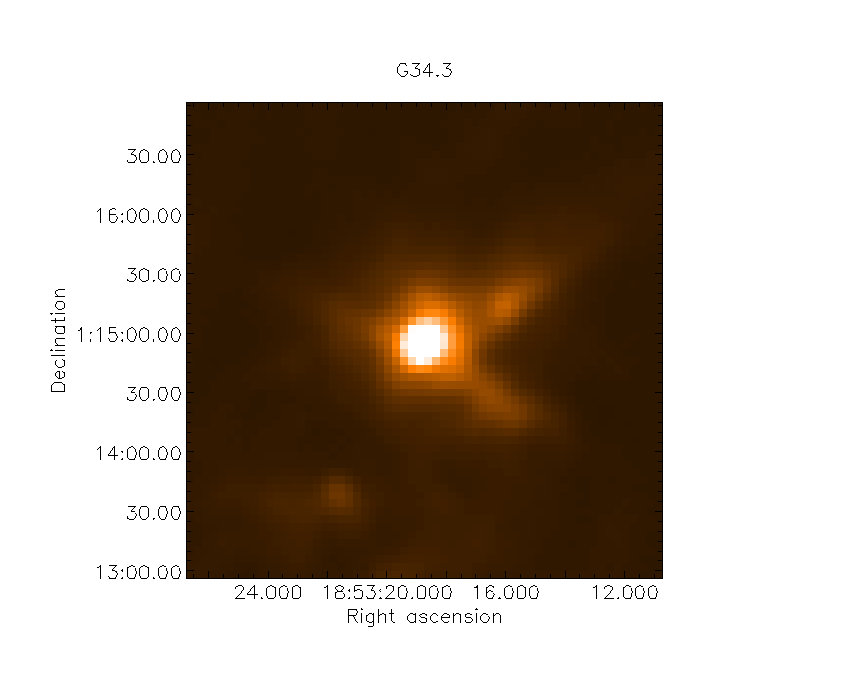

In [46]:
cropfile = picardoutput.datafiles[1]
kappa.lutable(mapping='linear', coltab='external', lut='$KAPPA_DIR/warm_lut', device='/PNG')
kappa.display(cropfile, mode='faint', device='cropping.png/PNG')
display(Image('cropping.png'))

Alternatively, we could crop using a CIRCLE, by passing a recpars file determining the CROP_METHOD and the MAP_RADIUS:

In [47]:
with open('recpars.lis', 'w') as f:
    f.write('[CROP_SCUBA2_IMAGES]\nCROP_METHOD=CIRCLE\nMAP_RADIUS=200.0\n')

%cat recpars.lis

picardoutput = picard.crop_scuba2_images([mapfile], recpars='recpars.lis')
print(picardoutput.runlog)
with open(picardoutput.runlog) as f:
    a = f.readlines()
print(''.join(a))

[CROP_SCUBA2_IMAGES]
CROP_METHOD=CIRCLE
MAP_RADIUS=200.0


INFO:starlink.wrapper:Running /Users/sarah/star-2017A/Perl/bin/perl /Users/sarah/star-2017A/bin/oracdr/src/bin/picard -log=sf -nodisplay -recpars=recpars.lis CROP_SCUBA2_IMAGES scuba2_map.sdf.


/Users/sarah/SeoulUsersMeeting/Starlink_Analysis/PICARDworkinglvx61cub/picard_39589.log
PICARD logfile - created on Wed Jan 31 03:05:41 2018 UT

ORAC Environment:

	Pipeline Version: 8ddff2d39647
	Instrument : <not required>
	Input  Dir : <undefined>
	Output Dir : /Users/sarah/SeoulUsersMeeting/Starlink_Analysis/PICARDworkinglvx61cub
	Calibration: <undefined>
	ORAC   Dir : /Users/sarah/star-2017A/bin/oracdr/src
	ORAC   Lib : /Users/sarah/star-2017A/bin/oracdr/src/lib/perl5
	Additional Recipe Dir   : <undefined>
	Additional Primitive Dir : <undefined>

System environment:

	Hostname        : phlebas.local
	User name       : 
	Perl version    : 5.018002
	Operating System: darwin
	System description: Darwin phlebas.local 14.5.0 Darwin Kernel Version 14.5.0: Mon Aug 29 21:14:16 PDT 2016; root:xnu-2782.50.6~1/RELEASE_X86_64 x86_64


PICARD Arguments: -log=sf -nodisplay -recpars=recpars.lis CROP_SCUBA2_IMAGES scuba2_map.sdf

Session:

Picard Says: No display will be used
Picard Says: Pre-sta

['/Users/sarah/SeoulUsersMeeting/Starlink_Analysis/PICARDworkinglvx61cub/adam_3958.sdf', '/Users/sarah/SeoulUsersMeeting/Starlink_Analysis/PICARDworkinglvx61cub/scuba2_map_crop.sdf']


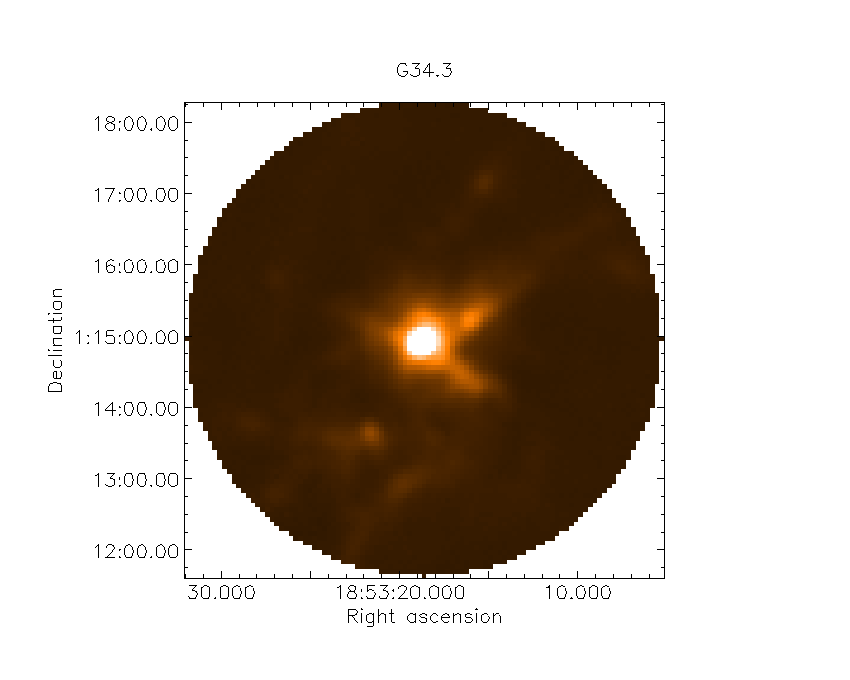

In [48]:
print(picardoutput.datafiles)
kappa.display(picardoutput.datafiles[1], mode='faint', device='cropping2.png/PNG')
display(Image('cropping2.png'))

### ARD Masking
**Extract out a ring of inner radius 70″, outer radius 100″ and centered on RA=18:53:18.7, Dec=1:14:54.3.**


We will use the [`ARDMASK`](http://www.starlink.ac.uk/cgi-bin/htxserver/sun95.htx/sun95.html?xref_ARDMASK) command to do this. First we create an ARD File, following the documentation at http://www.starlink.ac.uk/docs/sun183.htx/sun183.html

In [49]:
ardtext = """COFRAME(SKY, SYSTEM=FK5, equinox=2000)
CIRCLE(18:53:18.7,1:14:54.3, :1:40.) .AND. .NOT. CIRCLE(18:53:18.7,1:14:54.3, :1:10.0)
"""
with open('ARDMASK.dat', 'w') as f:
    f.write(ardtext)

%cat ARDMASK.dat

COFRAME(SKY, SYSTEM=FK5, equinox=2000)
CIRCLE(18:53:18.7,1:14:54.3, :1:40.) .AND. .NOT. CIRCLE(18:53:18.7,1:14:54.3, :1:10.0)


We can then perform the masking. We will set `inside=False` as we wish to set the regions outside the mask as BAD.

In [50]:
maskedfile = 'scuba2_annulus.sdf'
kappa.ardmask(mapfile + '(,)', ardfile='ARDMASK.dat', out=maskedfile, inside=False)

  const    BAD
 defpix    True
   comp    ALL
    in_    scuba2_map.sdf(,)
ardfile    ARDMASK.dat
 inside    False
    out    scuba2_annulus.sdf

And then we can view the image as normal:

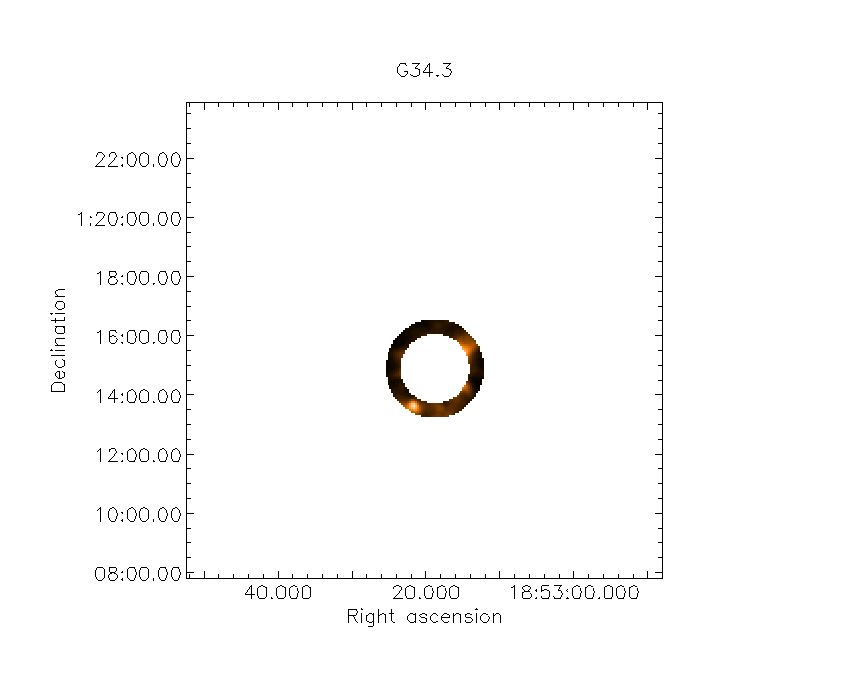

In [51]:
kappa.display(maskedfile, mode='faint', device='myfile.png/PNG')
display(Image('myfile.png'))

## Masking based on SNR

**Mask out all pixels in a cube or map with a detection of less than 5 sigma (try using `errclip`).**

[`errclip`](http://www.starlink.ac.uk/cgi-bin/htxserver/sun95.htx/sun95.html?xref_ERRCLIP) in KAPPA will mask out regions below a specified SNR limit, based on the Variance array in an NDF file. It can be used like:


In [52]:
kappa.errclip(cube, mode='SNR', out='co32_5sigmaclipped.sdf', limit=5.0)

  out    co32_5sigmaclipped.sdf
limit    5.0
 mode    SNR
  in_    co32_cube.sdf

Open the resulting map in Gaia (co32_5sigmaclipped.sdf) and take a look at it: you’ll see that the baseline and linewing regions are marked as bad, and only the strong parts of the line centre in bright regions are remaining.

### More advanced SNR masking
**Mask out all spectra in a cube where the peak of the spectra has a detection of less than 5 sigma. Try using makesnr, thresh, manic and copybad.**


First of all we will `collapse` the cube using the 'max' estimator to find out the brightness of the peak in each line, then we will create an SNR map of this using the default variance array (which is appropriately updated when we ran collapse). We threshold ([`thresh`](http://www.starlink.ac.uk/cgi-bin/htxserver/sun95.htx/sun95.html?xref_THRESH)) all pixels with an SNR of less than 5 in this collapsed map. 

We will then use the [`manic`](http://www.starlink.ac.uk/cgi-bin/htxserver/sun95.htx/sun95.html?xref_MANIC) command to create a mask that can be applied to a cube, by repeating the 2-D map across the correct plane (we have to use ndftrace to get the pixel boundaries of the original cube). We then use [`copybad`](http://www.starlink.ac.uk/cgi-bin/htxserver/sun95.htx/sun95.html?xref_COPYBAD) to copy over the bad pxiel mask to the cube.

In [53]:
# Create the cube of the maximum brightness in each spectra.
maxcollapsed = 'co32_max.sdf'
kappa.collapse(in_=cube, out=maxcollapsed, axis='vrad', estimator='max')

# Create an SNR map from this collapsed cube.
snrmap = 'max_snr.sdf'
kappa.makesnr(in_=maxcollapsed, out=snrmap, minvar=0.0)

# Now crop out all pixels with an SNR of less than 5: note that we have to use a 'fake' THRHI and NEWHI value that
# is far higher than we reached in our map.
mask2d = 'snrmask_5sig_2d.sdf'
kappa.thresh(in_=snrmap, thrlo=5.0, newlo='bad', thrhi=10000.0, newhi='bad', out=mask2d)

# Use ndftrace to check the pixel bounds of the original cube.
ndftrace = kappa.ndftrace(cube)
print('Pixel bounds of cube 3rd axis are:{} to {}'.format(ndftrace.lbound[2], ndftrace.ubound[2]))

# use those bounds to create a 3-D mask with the correct PIXEL values.
mask3d = 'snrmask_5sig_3d.sdf'
kappa.manic(in_=mask2d, out=mask3d, axes=[1,2,0], ubound=ndftrace.ubound[2], lbound=ndftrace.lbound[2] )


# Copy over the BAD values from the 3-D mask to a copy of the original CUBE
maskedcube = 'co32_5sigpeak.sdf'
kappa.copybad(in_=cube, ref=mask3d, out=maskedcube)

Pixel bounds of cube 3rd axis are:-940 to 939


   out    co32_5sigpeak.sdf
  nbad    9153720
   in_    co32_cube.sdf
 ngood    17245240
   ref    snrmask_5sig_3d.sdf
invert    False

You can then open this output cube 'co32_5sigpeak.sdf' in Gaia if you wish to explore it.


## Extracting values
**Using the co32_cube.sdf provided with this tutorial, extract spectra from the following coordinates:
6:34:37.7,4:12:37.20, 6:34;32.77,4:13:09.77, 6:34:24.47, 4:08:56.91**


We will use [`pluck`](http://www.starlink.ac.uk/cgi-bin/htxserver/sun95.htx/sun95.html?xref_PLUCK) to extract the spectra out into a container SDF file:

In [54]:
positions = ['6:34:37.7 4:12:37.20', '6:34:32.77 4:13:09.77', '6:34:24.47 4:08:56.91']
# Write these positions to a text file. You have to give a position for axis 3, but this can just be 1
filename = 'spectra_positions.txt'
with open(filename, 'w') as f:
    for i in positions:
        f.write(i + ' 1\n')

container = 'container_spectra.sdf'
kappa.pluck(in_=cube, axes='vrad', mode='file', coin='spectra_positions.txt', container=True,
            out=container, method='linear')

container    True
      tol    0.05
      in_    co32_cube.sdf
      out    /Users/sarah/SeoulUsersMeeting/Starlink_Analysis/container_spectra.PLUCK_3
     coin    spectra_positions.txt
 describe    False
     axes    vrad
     mode    file
   method    linear

We now have a container SDF file, where each spectra is found as `container_spectra.PLUCK_<index>` We can plot these with:

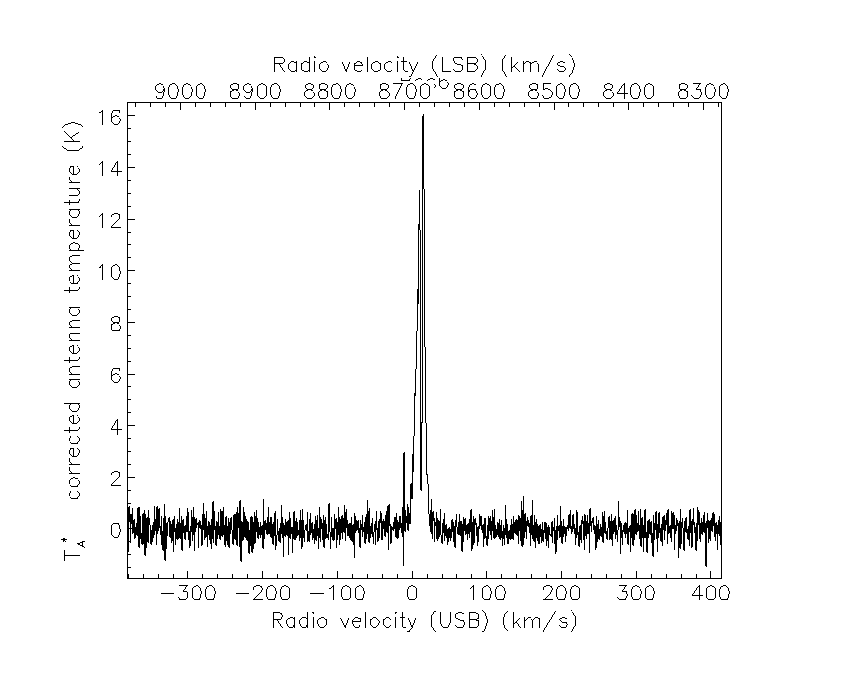

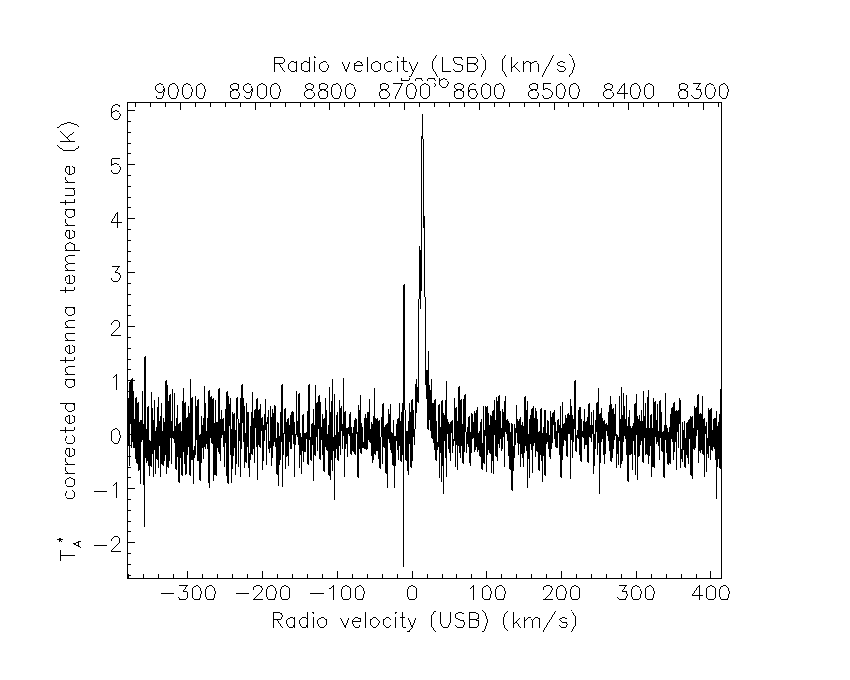

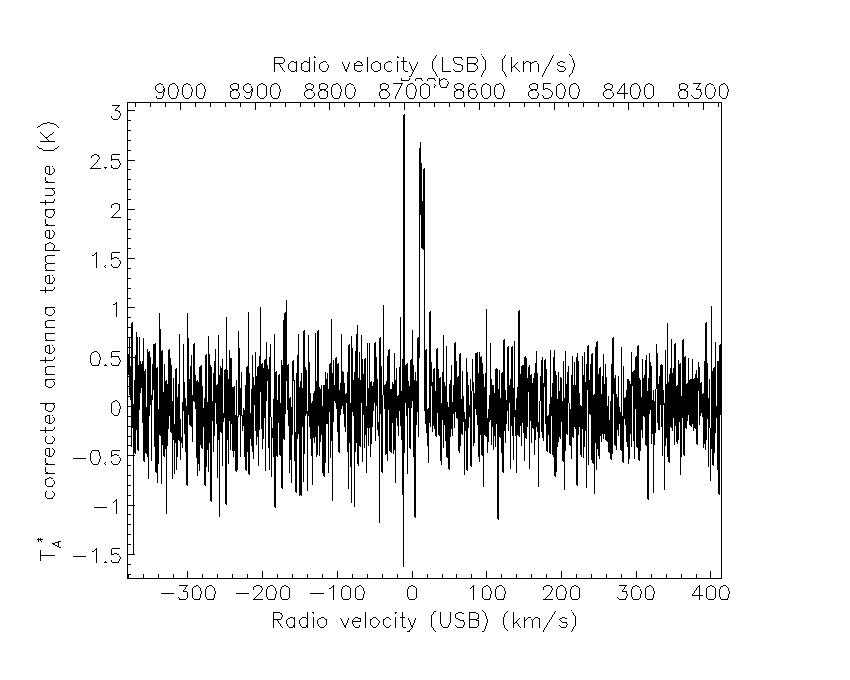

In [55]:
for i in range(1,4):
    
    spectra = container + '.PLUCK_{}'.format(i)
    pngname = 'spectra_{}.png'.format(i)
    kappa.linplot(spectra, device=pngname+'/PNG', style='^kappa_style.def')
    display(Image(pngname))
    

In [56]:
kappa.ndftrace('container_spectra.PLUCK_1')

 variance    True
    fubnd    [1.721905518363487, 0.0734987236835587, 414.46932447050517]
  exttype    ['_CHAR*80', 'SMURF_EXT', 'PROVENANCE']
  current    5
  quality    False
fpixscale    ['6.00000', '6.00000', '0.4233065']
   flabel    ['Right ascension', 'Declination', 'Radio velocity (USB)']
     zero    0.0
 fullaxis    False
     ndim    3
    funit    ['hh:mm:ss.s', 'ddd:mm:ss', 'km/s']
     dims    [1, 1, 1880]
     fdim    [3, 3, 3, 3, 3]
fullframe    False
  fullwcs    False
  fdomain    ['GRID', 'PIXEL', 'AXIS', 'FRACTION', 'SKY-DSBSPECTRUM']
   ubound    [1, 1, 939]
   nframe    5
     form    SIMPLE
    label    TA*   corrected antenna temperature
   ftitle    [ Data grid indices; first pixel at (1,1,1)
               Pixel coordinates; first pixel at (0.5,0.5,-940.5)
               Axis coordinates; first pixel at (0.5,0.5,-940.5)
               Normalised pixel coordinates; first pixel at (0.5,0.5,0.0002659574)
               3-d compound coordinate system
            

## Coordinate conversions

### Convert from RA/Dec to Galactic.

This is easily done with `wcsattrib`; just the same as we changed the System from Freq to Vrad at the start of this notebook, we can change from FK5 to Galactic. (We don't have to specify which axis we are changing the System of, as AST is clever enough to know that VRAD can only be applied to the Spectral axis, and that Galactic can only be applied to the Sky axes.

In [57]:
kappa.wcsattrib(ndf=cube, mode='set', name='System', newval='Galactic')
kappa.wcsattrib(ndf=mapfile, mode='set', name='System', newval='Galactic')
logging.root.setLevel('DEBUG')
a=kappa.ndftrace(cube)
a=kappa.ndftrace(mapfile)
logging.root.setLevel('INFO')

DEBUG:starlink.wrapper:['/Users/sarah/star-2017A/bin/kappa/ndftrace', 'co32_cube.sdf']
DEBUG:starlink.wrapper:
   NDF structure /Users/sarah/SeoulUsersMeeting/Starlink_Analysis/co32_cube:
      Title:  Ros6
      Label:  TA*   corrected antenna temperature
      Units:  K

   Shape:
      No. of dimensions:  3
      Dimension size(s):  119 x 118 x 1880
      Pixel bounds     :  -57:61, -58:59, -940:939
      Total pixels     :  26398960

   Data Component:
      Type        :  _REAL
      Storage form:  SIMPLE
      Bad pixels may be present

   Variance Component:
      Type        :  _REAL
      Storage form:  SIMPLE
      Bad pixels may be present

   World Co-ordinate Systems:
      Number of co-ordinate Frames: 5

      Current co-ordinate Frame (Frame 5):

        Frame title         : "3-d compound coordinate system"
        Domain              : SKY-DSBSPECTRUM
        First pixel centre  : 207.3974, -1.7666, -381.1352

           Axis 1:
              Label              : Gala

We can make a plot of this with, and it will be in Galactic Coordinates by default. If we convert to FITS, the resulting FITS file will also be in Galactic Coordinates.

In [58]:
convert.ndf2fits(mapfile, '!scuba2_galactic.fits')
from astropy.io import fits
hdr = fits.getheader('scuba2_galactic.fits')
hdr['CTYPE*']



CTYPE1  = 'GLAT-TAN'           / Type of co-ordinate on axis 1                  
CTYPE2  = 'GLON-TAN'           / Type of co-ordinate on axis 2                  
CTYPE3  = 'WAVE    '           / Type of co-ordinate on axis 3                  

We will then change our file back to RA/Dec, in case you wish to run this tutorial again.

In [59]:
kappa.wcsattrib(ndf=cube, mode='set', name='System', newval='FK5')
kappa.wcsattrib(ndf=mapfile, mode='set', name='System', newval='FK5')

   ndf    scuba2_map.sdf
 value    Compound
 state    False
newval    FK5
  name    System
  mode    set
 remap    True

## Fitting Spectra

**Use  SMURF's `fit1d` to fit spectra to all positions in your cube.**
 
Firstly we define a config file. We will fit a single Gausshermite2 to each spectrum, and mostly use the default values except to set the fitting range to be -12 to 88 km/s. We define our config file as:


In [60]:
with open('fit1d_config.def', 'w') as f:
    f.write('^$SMURF_DIR/smurf_fit1d.def\n')
    f.write('range=(-12.0,88.0)\n')

%cat fit1d_config.def

^$SMURF_DIR/smurf_fit1d.def
range=(-12.0,88.0)


Now we can run the [`fit1d`](http://www.starlink.ac.uk/cgi-bin/htxserver/sun258.htx/sun258.html?xref_FIT1D) command:

In [61]:
from starlink import smurf
logging.root.setLevel(logging.DEBUG)
smurf.fit1d(in_=cube, out='fittedprofiles.sdf', rms='!', config='^fit1d_config.def')

DEBUG:starlink.wrapper:['/Users/sarah/star-2017A/bin/smurf/fit1d', 'co32_cube.sdf', 'fittedprofiles.sdf', '!', 'config=^fit1d_config.def']
DEBUG:starlink.wrapper:Copying input file 1 to output for fitting...
Fitting data using 1 GAUSSHERMITE2(s) over pixel range [873,1109]
...Will use 4 threads to fit 14042 profiles.
(FitProfileThread   4) ...at profile  11000 -    470 of   3512 (i=20678120)
(FitProfileThread   1) ...at profile   1000 -   1000 of   3510 (i= 1878120)
(FitProfileThread   4) ...at profile  12000 -   1470 of   3512 (i=22558120)
(FitProfileThread   1) ...at profile   2000 -   2000 of   3510 (i= 3758120)
(FitProfileThread   4) ...at profile  13000 -   2470 of   3512 (i=24438120)
(FitProfileThread   1) ...at profile   3000 -   3000 of   3510 (i= 5638120)
(FitProfileThread   4) ...at profile  14000 -   3470 of   3512 (i=26318120)
...Writing parameter cubes and finishing up.



config    ^fit1d_config.def
   in_    co32_cube.sdf
   out    fittedprofiles.sdf

You can create a residual cube to also analyse with `sub`:

In [62]:
kappa.sub(in1='fittedprofiles.sdf', in2=cube, out='residuals.sdf' )

DEBUG:starlink.wrapper:['/Users/sarah/star-2017A/bin/kappa/sub', 'fittedprofiles.sdf', 'co32_cube.sdf', 'residuals.sdf']


in1    fittedprofiles.sdf
in2    co32_cube.sdf
out    residuals.sdf

## Clumpfinding

**Task: Use CUPID to find clumps in a SCUBA-2 map.**

First of all make a FellWalker parameter file -- see the documentation on CUPID's FINDCLUMPS at http://www.starlink.ac.uk/cgi-bin/htxserver/sun255.htx/sun255.html?xref_FINDCLUMPS for all the available parameters. We're going to find clups that have a peak of at least 5 times the RMS, and we are only going to follow clumps down to 3 times the RMS. We will divide emission into seperate clumps if there is at least a 3 sigma dip between the peaks.

All of these are defined on the basis of a single RMS value; If you want to identify clumps based on a varying noise across the map, I would recommend performing your clumpfind on an SNR map, and setting the RMS to a value of 1.

In [63]:
f = open('fellwalker_params.def', 'w')
f.write('\n'.join(['FellWalker.Noise=3*RMS',
                'FellWalker.MinHeight=5*RMS',
                'FellWalker.MinDip=3*RMS',]))
f.close()

In [64]:
%cat fellwalker_params.def

FellWalker.Noise=3*RMS
FellWalker.MinHeight=5*RMS
FellWalker.MinDip=3*RMS

Now we will use this parameter value to perform our clumpfinding. We are going to create an output FITS catalogue (`outct=clumpcat.FITS`) as well as our output clump mask, and we are using the `fellwalker` algorithm. Normally, CUPID will default to using the square root of the mean of the variance array of the input map; however, it will only use this after it prompts you to accept that. As it an't prompt you from within Python, if you want to use this default value, you need to pass the magic 'accept' value to the RMS keyword, like so:

In [65]:
from starlink import cupid
clumpfile = 'scuba2_clumps.sdf'
findclumps = cupid.findclumps(mapfile, out=clumpfile, outcat='clumpcat.FITS',
                              method='fellwalker', deconv=False, rms='accept')
print(findclumps)

DEBUG:starlink.wrapper:['/Users/sarah/star-2017A/bin/cupid/findclumps', 'scuba2_map.sdf', 'scuba2_clumps.sdf', 'outcat=clumpcat.FITS', 'deconv=False', 'rms=accept', 'method=fellwalker']
DEBUG:starlink.wrapper:

FellWalker:
75 clumps rejected because they contain too few pixels.
3 further clumps rejected because they include too many bad pixels.
15 usable clumps found.


Configuration parameters:
   FELLWALKER.ALLOWEDGE=1
   FELLWALKER.CLEANITER=1
   FELLWALKER.DUMPPEAK=0
   FELLWALKER.DUMPWALK=-1
   FELLWALKER.FLATSLOPE=65.207128531233
   FELLWALKER.FWHMBEAM=2
   FELLWALKER.MAXBAD=0.05
   FELLWALKER.MAXJUMP=4
   FELLWALKER.MINDIP=130.414257062466
   FELLWALKER.MINHEIGHT=130.414257062466
   FELLWALKER.MINPIX=7
   FELLWALKER.NOISE=130.414257062466
   FELLWALKER.RMS=65.207128531233





 outcat    clumpcat.FITS
    in_    scuba2_map.sdf
  shape    NONE
 deconv    False
    rms    65.207128531233
repconf    True
nclumps    15
 method    fellwalker
    out    scuba2_clumps.sdf
 wcspar    True
backoff    True


Alternatively you can measure the default RMS with stats, and directly give that value as a float:

In [66]:
rmsval = np.sqrt(kappa.stats(mapfile, comp='VARIANCE').mean)
print(rmsval)

DEBUG:starlink.wrapper:['/Users/sarah/star-2017A/bin/kappa/stats', 'scuba2_map.sdf', 'comp=VARIANCE']
DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /Users/sarah/SeoulUsersMeeting/Starlink_Analysis/scuba2_map

      Title                     : G34.3
      NDF array analysed        : VARIANCE

         Pixel sum              : 169857682.031761
         Pixel mean             : 4251.96961128869
         Standard deviation     : 16891.3343391067
         Skewness               : 23.4329521701514
         Kurtosis               : 1282.05352108669
         Minimum pixel value    : 113.181068377439
            At pixel            : (-3, 23, 1)
            Co-ordinate         : (18:53:19.667, 1:16:26.30, 0.00085)
         Maximum pixel value    : 1339352.8589341
            At pixel            : (-13, 122, 1)
            Co-ordinate         : (18:53:22.334, 1:23:02.30, 0.00085)
         Total number of pixels : 58081
         Number of pixels used  : 39948 (68.8%)
         

65.2071285312326


The output file `scuba2_clumps.sdf` is a mask file, where every pixel inside a clump has a value of the clump ID. Every pixel not in a clump is set bad. It looks like:

DEBUG:starlink.wrapper:['/Users/sarah/star-2017A/bin/kappa/lutable', 'linear', 'external', '$KAPPA_DIR/warm_lut', 'device=/PNG']
DEBUG:starlink.wrapper:['/Users/sarah/star-2017A/bin/kappa/display', 'scuba2_clumps.sdf', 'low=1', 'device=clumps.png/PNG', 'keystyle=^kappa_style.def', 'badcol=grey', 'high=15', 'style=^kappa_style.def', 'key=True', 'mode=scale']


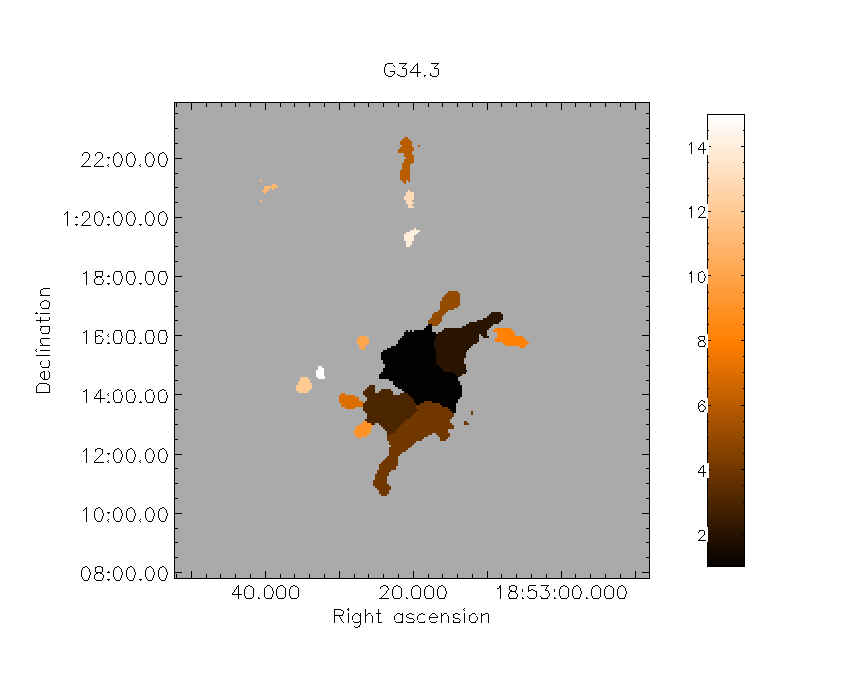

In [67]:
kappa.lutable(mapping='linear', coltab='external', lut='$KAPPA_DIR/warm_lut', device='/PNG')
kappa.display(clumpfile, device='clumps.png/PNG', mode='scale',
              low=1, high=findclumps.nclumps, key=True, badcol='grey',
             style='^kappa_style.def', keystyle='^kappa_style.def')
display(Image('clumps.png'))

This is a mask file where every pixel inside a clump has a value of the clump ID. Every pixel not in a clump is set bad.

You can also see the actual data values from the original clumps in the `CUPID.CLUMPS` extension array. You can access and view these with the: 
`<ndfname>.MORE.CUPID.CLUMPS(<clump_index>)` syntax. E.g., to display the 3rd Clump (the indexing starts at 1) you could do:

DEBUG:starlink.wrapper:['/Users/sarah/star-2017A/bin/kappa/display', 'scuba2_clumps.sdf.MORE.CUPID.CLUMPS(3)', 'device=clump3.png/PNG', 'keystyle=^kappa_style.def', 'badcol=grey', 'style=^kappa_style.def', 'key=True', 'mode=faint']
DEBUG:starlink.wrapper:Data will be scaled from 64.8516301199062 to 3578.63410082303.



scuba2_clumps.sdf.MORE.CUPID.CLUMPS(3)


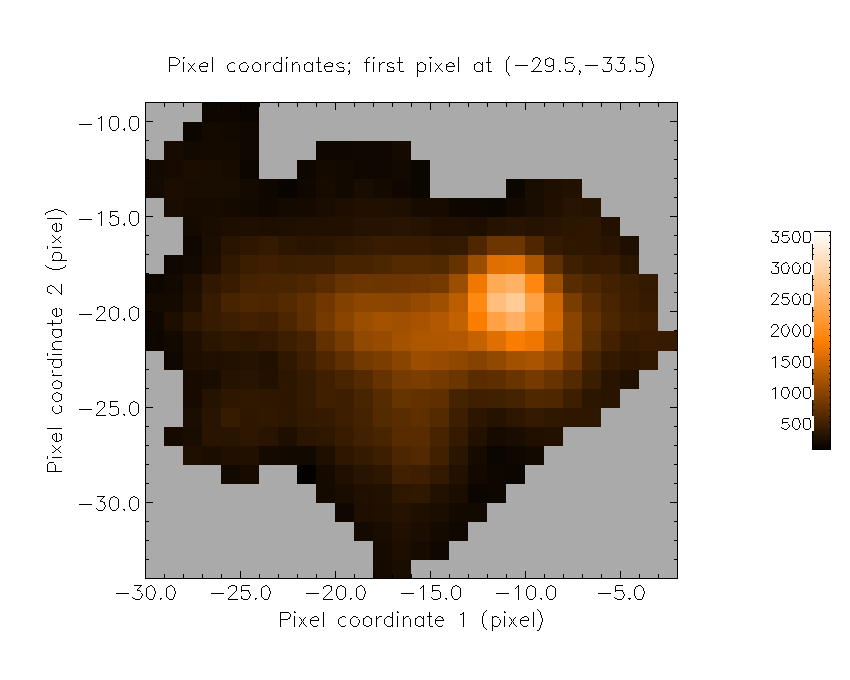

In [68]:
clumpname = clumpfile + '.MORE.CUPID.CLUMPS(3)'
print(clumpname)
kappa.display(clumpname, device='clump3.png/PNG', mode='faint', key=True, badcol='grey',
             style='^kappa_style.def', keystyle='^kappa_style.def')
display(Image('clump3.png'))

You can also copy them out with `ndfcopy`:

In [69]:
kappa.ndfcopy(clumpfile + '.MORE.CUPID.CLUMPS(3)', out='clump3.sdf')
kappa.stats('clump3.sdf')

DEBUG:starlink.wrapper:['/Users/sarah/star-2017A/bin/kappa/ndfcopy', 'scuba2_clumps.sdf.MORE.CUPID.CLUMPS(3)', 'clump3.sdf']
DEBUG:starlink.wrapper:['/Users/sarah/star-2017A/bin/kappa/stats', 'clump3.sdf']
DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /Users/sarah/SeoulUsersMeeting/Starlink_Analysis/clump3

      Title                     : <undefined>
      NDF array analysed        : DATA

         Pixel sum              : 217760.157629768
         Pixel mean             : 504.074438957797
         Standard deviation     : 438.714150784008
         Skewness               : 2.38409274894807
         Kurtosis               : 6.9119204657463
         Minimum pixel value    : 57.7234087070525
            At pixel            : (-21, -28)
            Co-ordinate         : (-21.5, -28.5)
         Maximum pixel value    : 2856.87137464058
            At pixel            : (-10, -19)
            Co-ordinate         : (-10.5, -19.5)
         Total number of pixels : 700
   

 numgood    432
   total    217760.15762976825
   sigma    438.71415078400764
mincoord    [-21.5, -28.5]
    comp    DATA
 maximum    2856.8713746405797
maxcoord    [-10.5, -19.5]
  maxpos    [-10, -19]
  numbad    268
skewness    2.3840927489480688
    mean    504.07443895779653
  numpix    700
  maxwcs    -10.5, -19.5
kurtosis    6.911920465746302
     ndf    clump3.sdf
  minpos    [-21, -28]
  minwcs    -21.5, -28.5
 minimum    57.72340870705253
   order    False

Note that if you use GaussClumps the output maps are slightly different, as that algorithm fits Gaussians and subtracts them rather than merely assigning pixels entirely to one pixel or another. Please see the documentation for more details.

## Beamfit
Another extremely useful command is KAPPA's `beamfit`. This has a few quirks of usage.

First of all, when you provide the initial position this is surprisingly supplied as a `string`, rather than a vector, and therefore KAPPA actually requires an extra set of quotes around it rather annoyingly. 

We will first of all use `stats` to identify the peak of our map, so that we can fit a beam to it.

In [70]:
stats=kappa.stats(mapfile)
print(stats.maxcoord)

DEBUG:starlink.wrapper:['/Users/sarah/star-2017A/bin/kappa/stats', 'scuba2_map.sdf']
DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /Users/sarah/SeoulUsersMeeting/Starlink_Analysis/scuba2_map

      Title                     : G34.3
      NDF array analysed        : DATA

         Pixel sum              : 3818111.21756118
         Pixel mean             : 95.5770305787818
         Standard deviation     : 887.221109188862
         Skewness               : 29.1078653182233
         Kurtosis               : 1147.2814951589
         Minimum pixel value    : -800.101899601974
            At pixel            : (-102, -10, 1)
            Co-ordinate         : (18:53:46.073, 1:14:14.29, 0.00085)
         Maximum pixel value    : 48378.6498812848
            At pixel            : (0, 0, 1)
            Co-ordinate         : (18:53:18.867, 1:14:54.30, 0.00085)
         Total number of pixels : 58081
         Number of pixels used  : 39948 (68.8%)
         No. of pixels exclude

[-1.3381681735838045, 0.021788981266010584, 0.00085]


`stats` will report angular coordinate positions in radians. As we have set our map to be in FK5 coordinates, we need to alter this to be Hours in RA and Degress in Dec. We can use the Astropy coordinates module to do this conversion:

In [83]:
maxcoord = stats.maxcoord[0:2]
print(maxcoord)

import astropy.coordinates as coord
import  astropy.units as u
co = coord.FK5(ra = maxcoord[0]*u.rad, dec = maxcoord[1]*u.rad)
ra = str(co.ra.to(u.hourangle))
dec = str(co.dec.to(u.degree))
print(ra, dec)

[-1.3381681735838045, 0.021788981266010584]
18h53m18.8667s 1d14m54.3s


We can now run `beamfit` using this position as our initial guess. We will fit a single Gaussian via:

In [82]:
logging.root.setLevel('DEBUG')
beamfit = kappa.beamfit(mapfile, pos='"{},{}"'.format(ra, dec),mode='interface')
print(beamfit)

DEBUG:starlink.wrapper:['/Users/sarah/star-2017A/bin/kappa/beamfit', 'scuba2_map.sdf', 'mode=interface', 'pos="18h53m18.8667s,1d14m54.3s"']
DEBUG:starlink.wrapper:    Co-ordinates    : RA(hh:mm:ss.sss) Dec(ddd:mm:ss.ss)

    Centre          : (18:53:18.702,1:14:55.79) +/- (0.025,0.024) arcsec
    Offset          : 2.940 +/- 0.024 arcseconds from sky reference position
    FWHM (major)    : 24.048 +/- 0.061 arcseconds
    FWHM (minor)    : 21.769 +/- 0.055 arcseconds
    Orientation     : 28.98 +/- 0.179E-01 degrees (measured from North through East)
    Amplitude       : 37894.5539155129 +/- 95.0890507005049
    Background      : 60.4092577565704 +/- 1.45244707634456
    Shape exponent  : 2.000

    RMS fit error   : 289.74273447272





variance    False
  orient    [28.981223569687966, 1.0270516883128409]
     ndf    scuba2_map.sdf
     sum    1404876.214279612
     pos    18h53m18.8667s,1d14m54.3s
  fixpos    False
 minfwhm    [0.00010554087246950134, 2.6675258628909646e-07]
  refoff    ['0:00:02.9', '0:00:00.0']
 fixfwhm    False
    mode    interface
    back    [60.409257756570405, 1.4524470763445612]
 majfwhm    [0.00011658585872160135, 2.9662588832441424e-07]
  centre    ['18:53:18.702 1:14:55.8', '0:00:00.002 0:00:00.0']
     rms    289.74274
   gauss    True
  fixsep    False
   gamma    [2.0, -1.7976931348623157e+308]
describe    False
circular    False
     amp    [37894.553915512886, 95.08905070050488]


To determine what units the outputs are in, please see the KAPPA BEAMFIT documentation: http://www.starlink.ac.uk/cgi-bin/htxserver/sun95.htx/sun95.html?xref_BEAMFIT . Most of the outputs report both the fitted value and the error on that fit. 

The string return value `centre` is returned in the formated string of the current WCS frame of the input NDF (here, galactic coordinates in degrees). On the other hand, the FWHM values as floats `minfwhm` and `maxfwhm` are reported in radians.


In [84]:
print('CENTRE value is {}'.format(beamfit.centre))

print('FWHM fits. MAJ:  {:.2E}±{:.2E}, MIN:  {:.2E}±{:.2E} radians'.format(*beamfit.majfwhm, *beamfit.minfwhm))

majfwhm = 60.0*60.0*np.rad2deg(np.array(beamfit.majfwhm))
minfwhm = 60.0*60.0*np.rad2deg(np.array(beamfit.minfwhm))
print('in arcsec. MAJ:  {:.2E}±{:.2E} ", MIN:  {:.2E}±{:.2E} "'.format(*majfwhm, *minfwhm))

CENTRE value is ['18:53:18.702 1:14:55.8', '0:00:00.002 0:00:00.0']
FWHM fits. MAJ:  1.17E-04±2.97E-07, MIN:  1.06E-04±2.67E-07 radians
in arcsec. MAJ:  2.40E+01±6.12E-02 ", MIN:  2.18E+01±5.50E-02 "
